In [25]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
# from config import username, password
import time
from pathlib import Path
import pickle

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble.forest import RandomForestClassifier
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.ticker as mticker

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_blobs
import seaborn as sns
from collections import Counter

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
# Import the data
file_path = "Resources/US_Accidents_June20.csv"
cleaned_df = pd.read_csv(file_path)
cleaned_df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [3]:
filtered_cleaned_df = cleaned_df.drop(['Country'], axis=1)

In [4]:
# Define target vector
X = filtered_cleaned_df.copy()

In [5]:
X.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


# Graphs

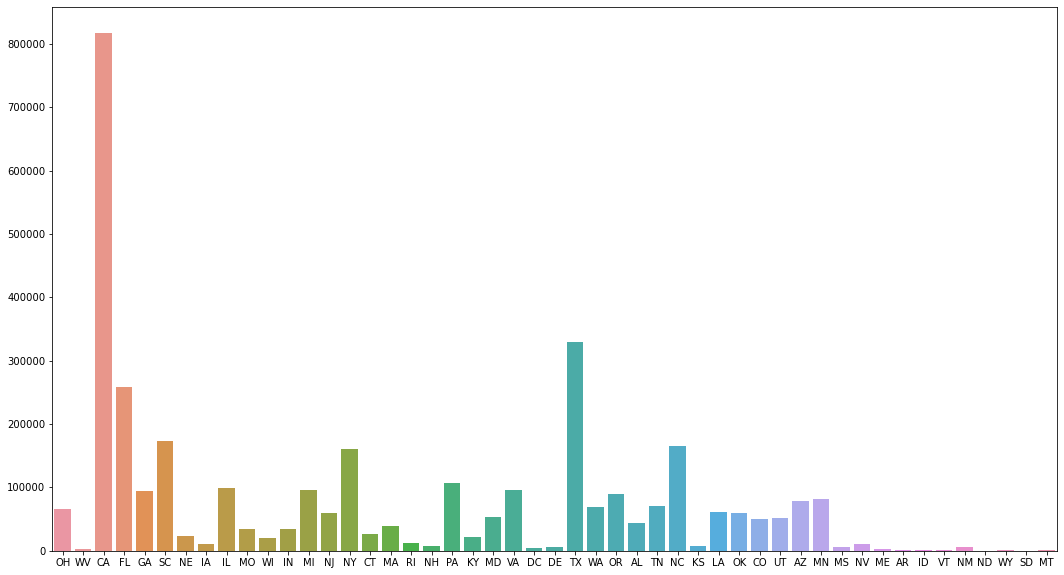

In [38]:
states = cleaned_df.State.unique()
state_graph=[]
for i in cleaned_df.State.unique():
    state_graph.append(cleaned_df[cleaned_df['State']==i].count()['ID'])

fig,ax = plt.subplots(figsize=(18,10))
sns.barplot(states,state_graph)

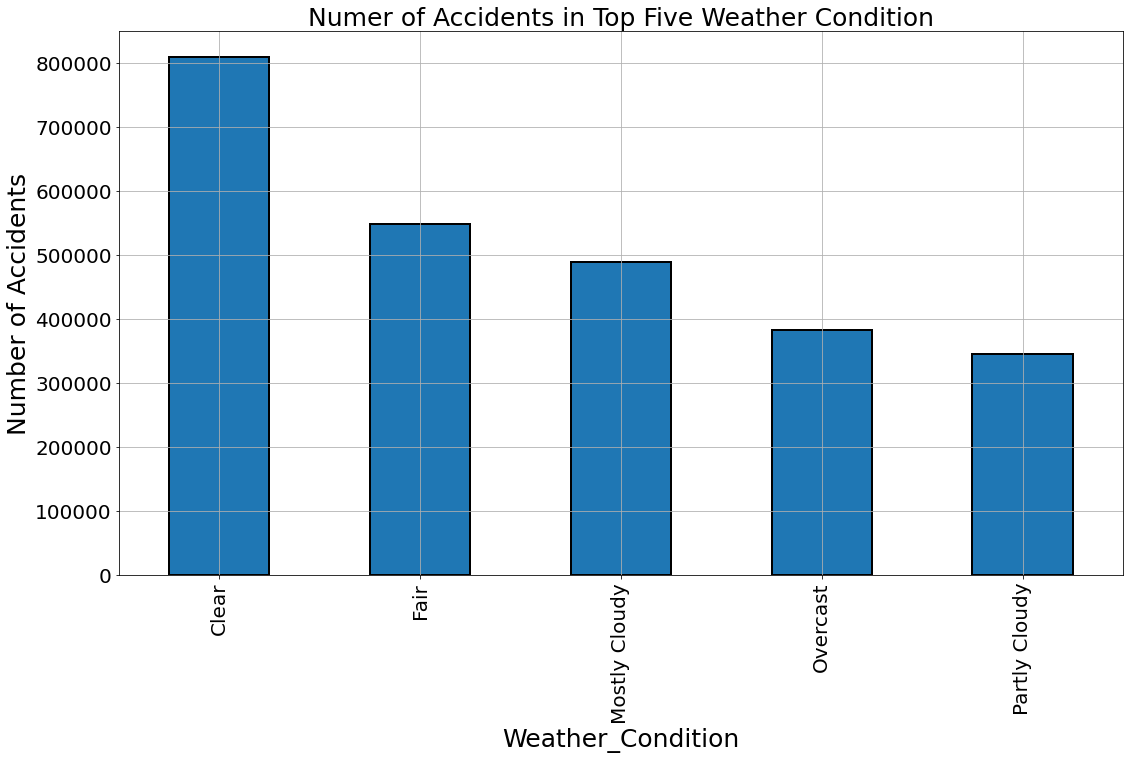

In [10]:
fig, ax=plt.subplots(figsize=(18,10))
cleaned_df['Weather_Condition'].value_counts().sort_values(ascending=False).head(5).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Weather_Condition',fontsize=25)
plt.ylabel('Number of Accidents',fontsize=25)
ax.tick_params(labelsize=20)
plt.title('Numer of Accidents in Top Five Weather Condition',fontsize=25)
plt.grid()
plt.ioff()

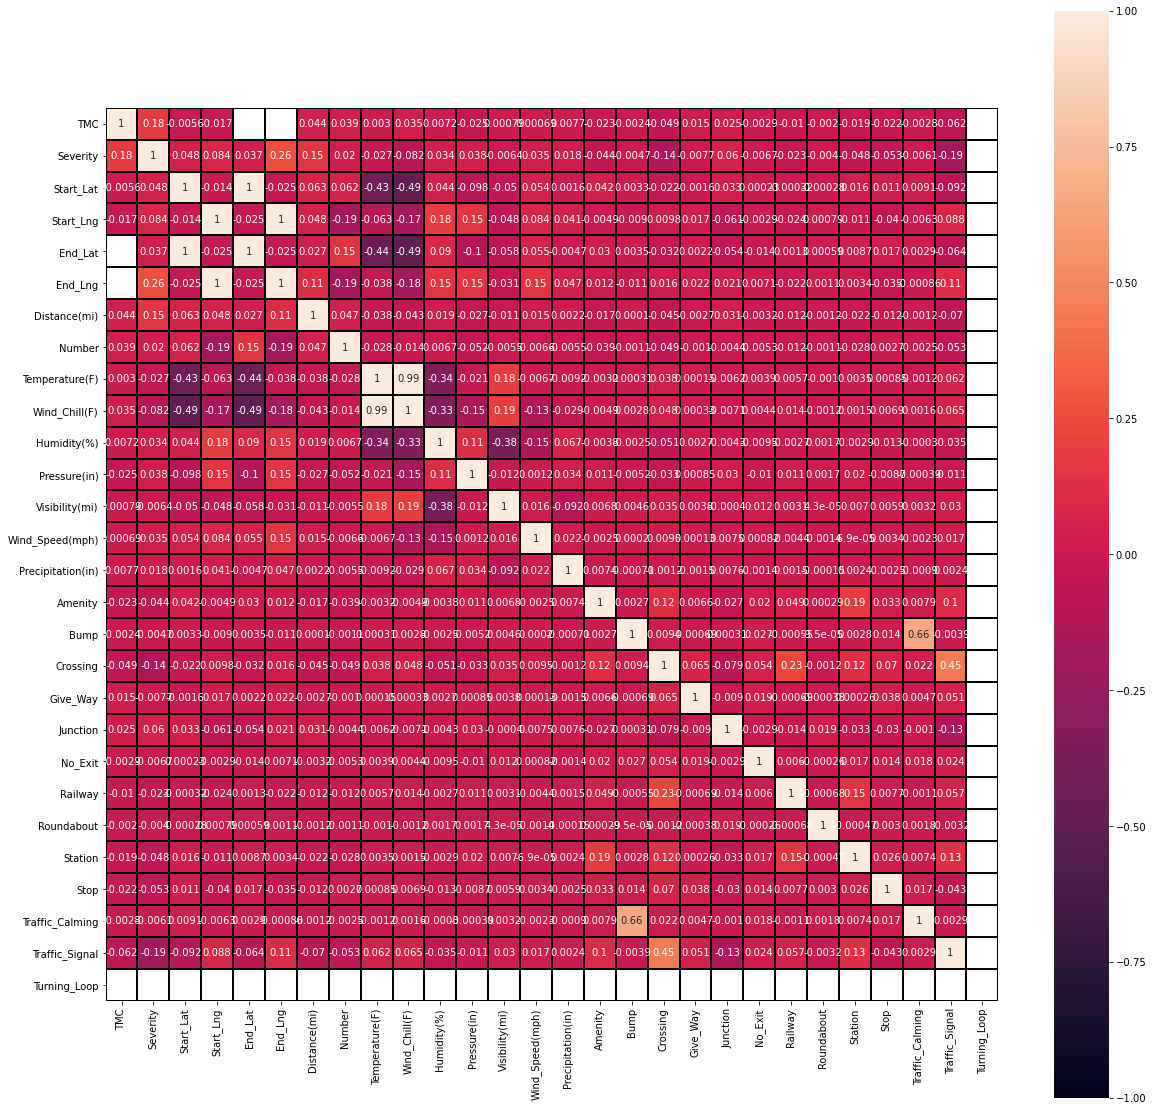

In [11]:
fig=plt.gcf()
fig.set_size_inches(20,20)
fig=sns.heatmap(cleaned_df.corr(),
                annot=True,
                linewidths=1,
                linecolor='k',
                square=True,
                mask=False, 
                vmin=-1, 
                vmax=1,
                cbar_kws={"orientation": "vertical"},cbar=True)

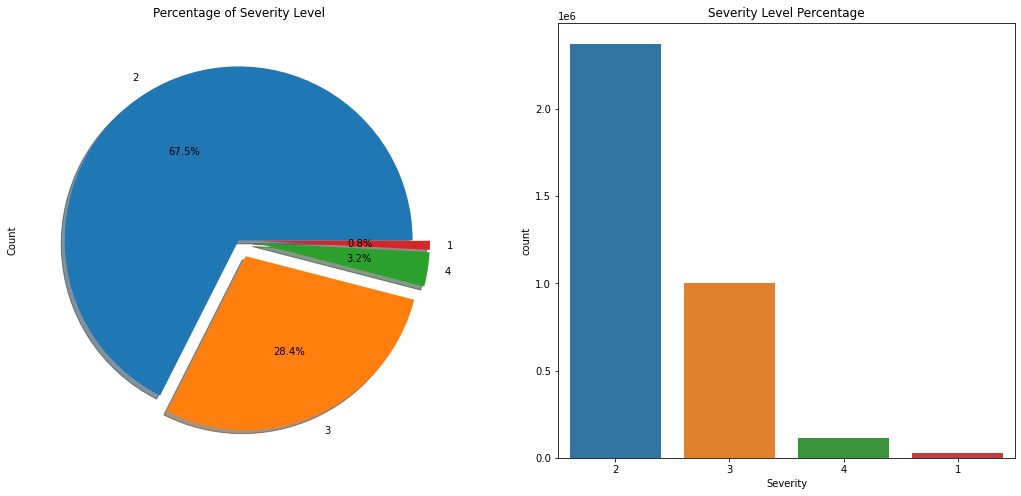

In [28]:
f,ax=plt.subplots(1,2,figsize=(18,8))
cleaned_df['Severity'].value_counts().plot.pie(explode=[0,0.1,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Percentage of Severity Level')
ax[0].set_ylabel('Count')
sns.countplot('Severity',data=cleaned_df,ax=ax[1],order=cleaned_df['Severity'].value_counts().index)
ax[1].set_title('Severity Level Percentage')
plt.show()

C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\to

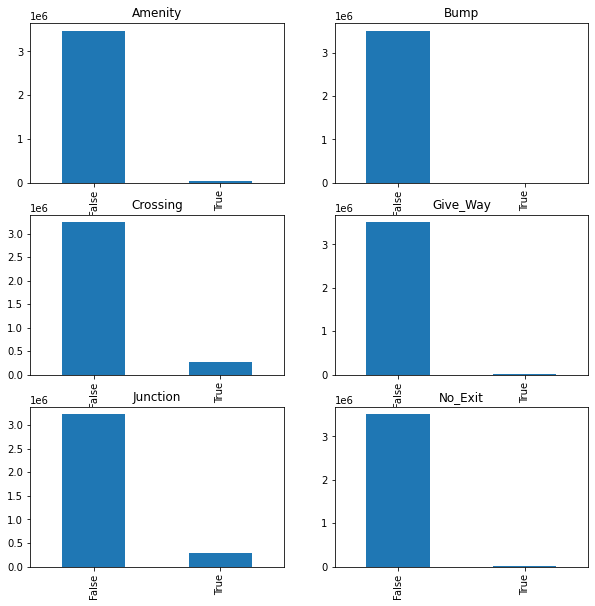

In [14]:
fig = plt.figure(figsize=(10,10)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (0, 0))
cleaned_df['Amenity'].value_counts().plot(kind='bar', 
                                     title='Amenity')
plt.subplot2grid(fig_dims, (0, 1))
cleaned_df['Bump'].value_counts().plot(kind='bar', 
                                     title='Bump')
plt.subplot2grid(fig_dims, (1, 0))
cleaned_df['Crossing'].value_counts().plot(kind='bar', 
                                     title='Crossing')
plt.subplot2grid(fig_dims, (1, 1))
cleaned_df['Give_Way'].value_counts().plot(kind='bar', 
                                     title='Give_Way')

plt.subplot2grid(fig_dims, (2, 0))
cleaned_df['Junction'].value_counts().plot(kind='bar', 
                                     title='Junction')
plt.subplot2grid(fig_dims, (2, 1))
cleaned_df['No_Exit'].value_counts().plot(kind='bar', 
                                     title='No_Exit')



C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\to

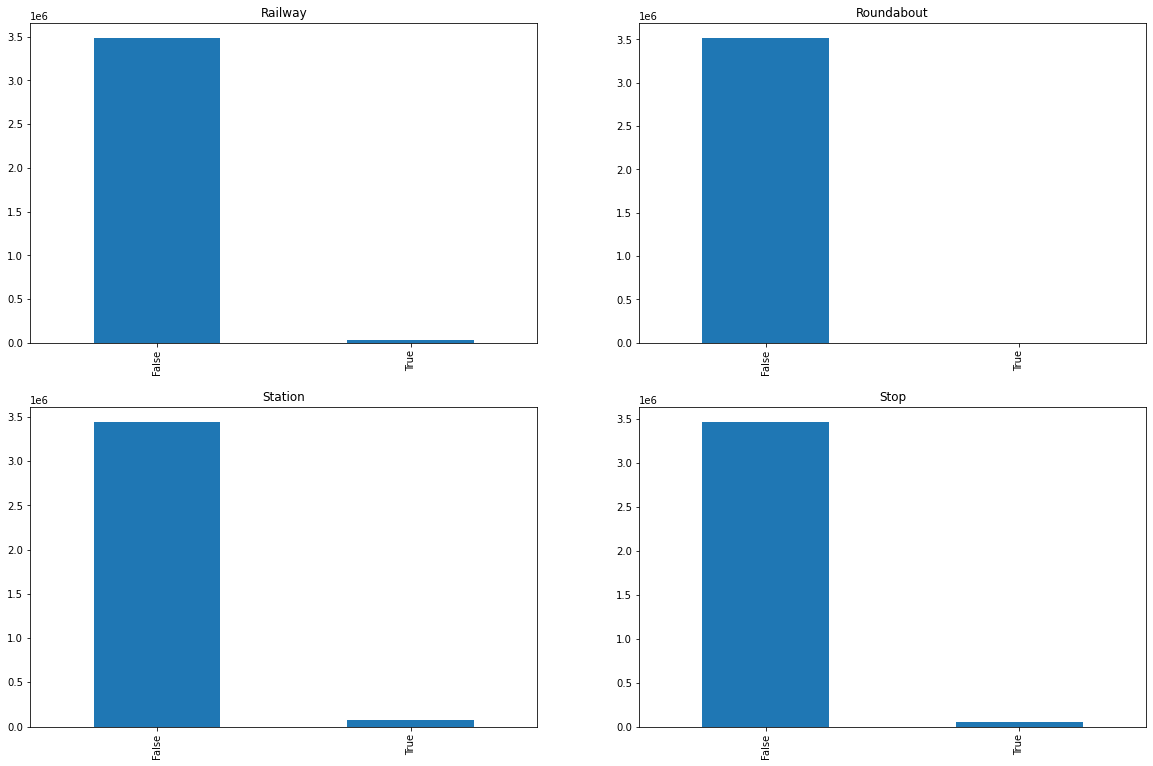

In [15]:
fig = plt.figure(figsize=(20,20)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (1, 0))
cleaned_df['Railway'].value_counts().plot(kind='bar', 
                                     title='Railway')

plt.subplot2grid(fig_dims, (1, 1))
cleaned_df['Roundabout'].value_counts().plot(kind='bar', 
                                     title='Roundabout')

plt.subplot2grid(fig_dims, (2, 0))
cleaned_df['Station'].value_counts().plot(kind='bar', 
                                     title='Station')

plt.subplot2grid(fig_dims, (2, 1))
cleaned_df['Stop'].value_counts().plot(kind='bar', 
                                     title='Stop')

C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\to

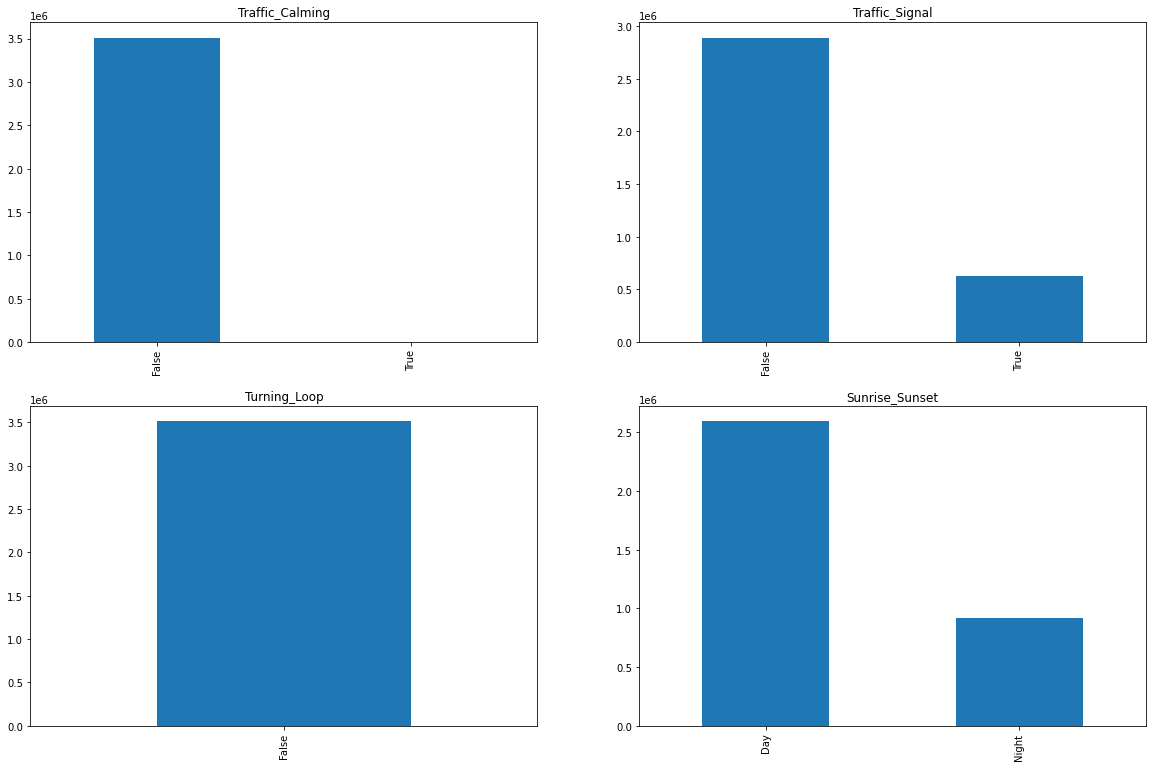

In [16]:
fig = plt.figure(figsize=(20,20)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (1, 0))
cleaned_df['Traffic_Calming'].value_counts().plot(kind='bar', 
                                     title='Traffic_Calming')

plt.subplot2grid(fig_dims, (1, 1))
cleaned_df['Traffic_Signal'].value_counts().plot(kind='bar', 
                                     title='Traffic_Signal')

plt.subplot2grid(fig_dims, (2, 0))
cleaned_df['Turning_Loop'].value_counts().plot(kind='bar', 
                                     title='Turning_Loop')

plt.subplot2grid(fig_dims, (2, 1))
cleaned_df['Sunrise_Sunset'].value_counts().plot(kind='bar', 
                                     title='Sunrise_Sunset')

C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Rob\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\to

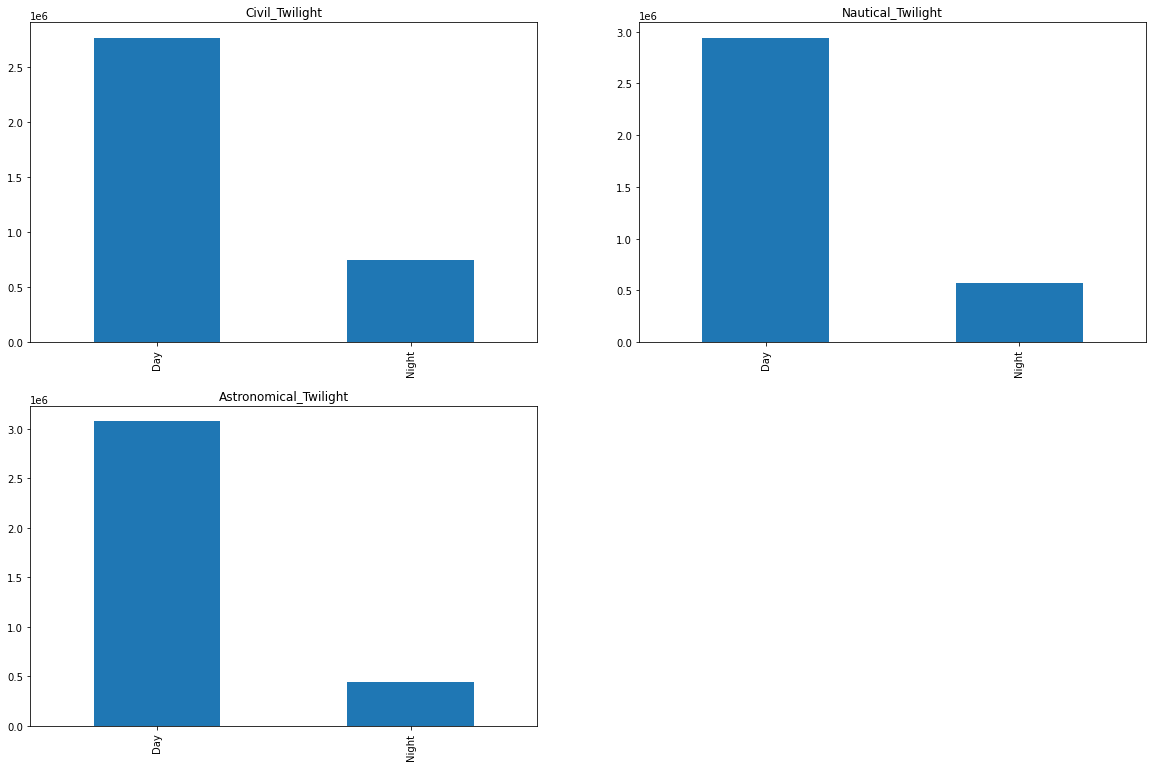

In [17]:
fig = plt.figure(figsize=(20,20)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (1, 0))
cleaned_df['Civil_Twilight'].value_counts().plot(kind='bar', 
                                     title='Civil_Twilight')

plt.subplot2grid(fig_dims, (1, 1))
cleaned_df['Nautical_Twilight'].value_counts().plot(kind='bar', 
                                     title='Nautical_Twilight')

plt.subplot2grid(fig_dims, (2, 0))
cleaned_df['Astronomical_Twilight'].value_counts().plot(kind='bar', 
                                     title='Astronomical_Twilight')